In [1]:
!pip install -q -U autogluon.tabular

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, which is not installed.
s3fs 2024.3.1 requires aiohttp!=4.0.0a0,!=4.0.0a1, which is not installed.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


# Imports and Configs

In [2]:
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import glob

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [3]:
TIME_LIMIT = 3600 * 11
N_FOLDS = 5
SEED = 27
TARGET = 'Target'

# Loading and Combining the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [5]:
original = pd.read_csv('/kaggle/input/predict-students-dropout-and-academic-success/data.csv')
train = pd.concat([train, original], axis=0, ignore_index=True)

train.shape

(80942, 37)

In [6]:
train = TabularDataset(train)
test = TabularDataset(test)

# Training

In [7]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

histories = {}
oof_preds = np.zeros((len(train), train[TARGET].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train.drop(columns=TARGET), train[TARGET])):
    _train, _val = train.iloc[train_idx], train.iloc[val_idx]    

    predictor = TabularPredictor(
        label=TARGET,
        eval_metric='accuracy',
        problem_type='multiclass',
        verbosity=2
    ).fit(
        train_data=_train,
        time_limit=TIME_LIMIT // N_FOLDS,
        presets='best_quality',
        excluded_model_types = ['KNN', 'NN', 'NN_TORCH', 'FASTAI', 'RF'],
        save_space=True,
        hyperparameter_tune_kwargs={  
            'num_trials': 25,
            'scheduler' : 'local',
            'searcher'  : 'auto'
        },
#         feature_prune_kwargs={'force_prune': True}
    )
    
    fold_score = predictor.evaluate(_val)['accuracy']
    
    pred_probs = predictor.predict_proba(_val)
    preds = pred_probs.idxmax(axis=1).values
    oof_preds[val_idx] = pred_probs
    
    test_pred_probs = predictor.predict_proba(test)
    
    test_preds = test_pred_probs.idxmax(axis=1).values
    test_preds = pd.DataFrame({TARGET: test_preds}, index=test.index)
    test_preds.to_csv(f'fold_{fold_idx}_test_preds_{fold_score:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.to_csv(f'fold_{fold_idx}_test_pred_probs_{fold_score:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['summary'] = predictor.fit_summary()
    histories[f'Fold {fold_idx}']['leaderboard'] = predictor.leaderboard()
    histories[f'Fold {fold_idx}']['y'] = _val[TARGET].values
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = fold_score
    histories[f'Fold {fold_idx}']['auc'] = roc_auc_score(_val[TARGET], pred_probs, multi_class='ovo')
    
    
    print(f'Fold {fold_idx} - Accuracy: {fold_score}')
    
    shutil.rmtree("AutogluonModels")
    del predictor

No path specified. Models will be saved in: "AutogluonModels/ag-20240603_072510"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240603_072510/ds_sub_fit/sub_fit_ho.
2024-06-03 07:25:11,504	INFO util.py:124 -- Outdated packages:
  ipywidgets==7

  0%|          | 0/25 [00:00<?, ?it/s]

Will use sequential fold fitting strategy because import of ray failed. Reason: ray==2.9.0 detected. 2.10.0 <= ray < 2.11.0 is required. You can use pip to install certain version of ray `pip install ray==2.10.0` 
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 52. Best iteration is:
	[42]	valid_set's multi_error: 0.179708
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 32. Best iteration is:
	[32]	valid_set's multi_error: 0.17262
	Ran out of time, early stopping on iteration 32. Best iteration is:
	[32]	valid_set's multi_error: 0.181376
	Ran out of time, early stopping on iteration 33. Best iteration is:
	[33]	valid_set's multi_error: 0.182627
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[34]	valid_set's multi_error: 0.176095
	Ran out of time, early stopping on iteration 39. Best iteration i

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[54]	valid_set's multi_error: 0.169145
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[54]	valid_set's multi_error: 0.176789
	Ran out of time, early stopping on iteration 56. Best iteration is:
	[56]	valid_set's multi_error: 0.176928
	Ran out of time, early stopping on iteration 57. Best iteration is:
	[56]	valid_set's multi_error: 0.174427
	Ran out of time, early stopping on iteration 60. Best iteration is:
	[57]	valid_set's multi_error: 0.178874
	Ran out of time, early stopping on iteration 64. Best iteration is:
	[59]	valid_set's multi_error: 0.170674
	Ran out of time, early stopping on iteration 71. Best iteration is:
	[71]	valid_set's multi_error: 0.177231
	Ran out of time, early stopping on iteration 82. Best iteration is:
	[80]	valid_set's multi_error: 0.185571
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 27.
	Ran out of time, early stopping on iteration 40.
	Ran out of time, early stopping on iteration 41.
	Ran out of time, early stopping on iteration 43.
	Ran out of time, early stopping on iteration 46.
	Ran out of time, early stopping on iteration 47.
	Ran out of time, early stopping on iteration 56.
	Ran out of time, early stopping on iteration 70.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8124	 = Validation score   (accuracy)
	18.59s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1918.65s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8196	 = Validation score   (acc

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8261	 = Validation score   (accuracy)
	18.85s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1863.58s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 30. Best iteration is:
	[30]	valid_set's multi_error: 0.173315
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[30]	valid_set's multi_error: 0.180542
	Ran out of time, early stopping on iteration 36. Best iteration is:
	[35]	valid_set's multi_error: 0.17943
	Ran out of time, early stopping on iteration 38. Best iteration is:
	[35]	valid_set's multi_error: 0.176095
	Ran out of time, early stopping on iteration 40. Best iteration is:
	[40]	valid_set's multi_error: 0.178874

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 13.82s of the 832.64s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 13.82s of the 821.09s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 13.82s of the 807.87s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 13.82s of the 760.48s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 13.82s of the 756.14s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperpara

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 188. Best iteration is:
	[176]	valid_set's multi_error: 0.169734
	Ran out of time, early stopping on iteration 184. Best iteration is:
	[181]	valid_set's multi_error: 0.172597
	Ran out of time, early stopping on iteration 202. Best iteration is:
	[197]	valid_set's multi_error: 0.173956
	Ran out of time, early stopping on iteration 211. Best iteration is:
	[209]	valid_set's multi_error: 0.168891
	Ran out of time, early stopping on iteration 220. Best iteration is:
	[213]	valid_set's multi_error: 0.17025
	Ran out of time, early stopping on iteration 221. Best iteration is:
	[220]	valid_set's multi_error: 0.170991
	Ran out of time, early stopping on iteration 257. Best iteration is:
	[224]	valid_set's multi_error: 0.180133
	Ran out of time, early stopping on iteration 310. Best iteration is:
	[305]	valid_set's multi_error: 0.171485
	Stopping HPO to satisfy 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 208. Best iteration is:
	[190]	valid_set's multi_error: 0.16852
	Ran out of time, early stopping on iteration 222. Best iteration is:
	[216]	valid_set's multi_error: 0.17062
	Ran out of time, early stopping on iteration 269. Best iteration is:
	[241]	valid_set's multi_error: 0.168396
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.8304	 = Validation score   (accuracy)
	57.82s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 68.21s of the 6135.03s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 134.
	Ran out of time, early stopping on iteration 137.
	Ran out of time, early stopping on iteration 139.
	Ran out of time, early stopping on iteration 149.
	Ran out of time, early stopping on iteration 160.
	Ran out of time, early stopping on iteration 172.
	Ran out of time, early stopping on iteration 181.
	Ran out of time, early stopping on iteration 230.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8224	 = Validation score   (accuracy)
	60.6s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 68.21s of the 6074.29s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8217	 = Validation score

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8291	 = Validation score   (accuracy)
	48.7s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 68.21s of the 5970.95s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 117. Best iteration is:
	[117]	valid_set's multi_error: 0.169981
	Ran out of time, early stopping on iteration 117. Best iteration is:
	[110]	valid_set's multi_error: 0.172721
	Ran out of time, early stopping on iteration 123. Best iteration is:
	[118]	valid_set's multi_error: 0.175191
	Ran out of time, early stopping on iteration 127. Best iteration is:
	[127]	valid_set's multi_error: 0.167655
	Ran out of time, early stopping on iteration 132. Best iteration is:
	[113]	valid_set's multi_error

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.180111
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.185322
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.172721
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.180998
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.177292
	Ran out of time, early stopping on iteration 15. Best iteration is:
	[15]	valid_set's multi_error: 0.174944
	Ran out of time, early stopping on iteration 16. Best iteration is:
	[16]	valid_set's multi_error: 0.174203
	Ran out of time, early stopping on iteration 20. Best iteration is:
	[20]	valid_set's multi_error: 0.16852
	Stopping HPO to satisfy time limit...
Fi

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.183076
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.190882
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.181987
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.181492
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.180133
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.178774
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.177292
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's multi_error: 0.174944
	Stopping HPO to satisfy time limit...
Fit

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Ran out of time, early stopping on iteration 3.
	Ran out of time, early stopping on iteration 3.
	Ran out of time, early stopping on iteration 1.
	Ran out of time, early stopping on iteration 1.
	Ran out of time, early stopping on iteration 12.
	Ran out of time, early stopping on iteration 18.
	Ran out of time, early stopping on iteration 23.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	0.8282	 = Validation score   (accuracy)
	42.62s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 50.6s of the 2956.75s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L2 ...
	0.8297	 = Validation score   (accuracy)

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L2/T1 ...
	0.8317	 = Validation score   (accuracy)
	44.63s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 50.6s of the 2832.75s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.258555
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.259204
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.259081
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.237583
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.22387
	Ran o

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.832672    accuracy       1.634840  3517.616215                0.009557           4.314548            3       True        111
1       WeightedEnsemble_L2   0.832131    accuracy       0.015879   237.869425                0.008705           4.350817            2       True         56
2      LightGBM_r130_BAG_L1   0.831977    accuracy       0.001629    51.950254                0.001629          51.950254            1       True         18
3        XGBoost_r95_BAG_L2   0.831961    accuracy       1.615925  3198.195551                0.001368          48.617882            2       True        108
4        XGBoost_r22_BAG_L1   0.831730    accuracy       0.001452    59.257615                0.001452          59.257615            1       True        

No path specified. Models will be saved in: "AutogluonModels/ag-20240603_094121"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240603_094121/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1980s
AutoGluon will save models

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[52]	valid_set's multi_error: 0.181654
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[50]	valid_set's multi_error: 0.179569
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[52]	valid_set's multi_error: 0.180681
	Ran out of time, early stopping on iteration 55. Best iteration is:
	[52]	valid_set's multi_error: 0.183044
	Ran out of time, early stopping on iteration 60. Best iteration is:
	[60]	valid_set's multi_error: 0.184573
	Ran out of time, early stopping on iteration 62. Best iteration is:
	[58]	valid_set's multi_error: 0.179569
	Ran out of time, early stopping on iteration 69. Best iteration is:
	[66]	valid_set's multi_error: 0.180984
	Ran out of time, early stopping on iteration 70. Best iteration is:
	[70]	valid_set's multi_error: 0.178899
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 50. Best iteration is:
	[49]	valid_set's multi_error: 0.176511
	Ran out of time, early stopping on iteration 51. Best iteration is:
	[51]	valid_set's multi_error: 0.174705
	Ran out of time, early stopping on iteration 42. Best iteration is:
	[42]	valid_set's multi_error: 0.173454
	Ran out of time, early stopping on iteration 57. Best iteration is:
	[55]	valid_set's multi_error: 0.177206
	Ran out of time, early stopping on iteration 60. Best iteration is:
	[60]	valid_set's multi_error: 0.178179
	Ran out of time, early stopping on iteration 62. Best iteration is:
	[52]	valid_set's multi_error: 0.175539
	Ran out of time, early stopping on iteration 69. Best iteration is:
	[66]	valid_set's multi_error: 0.175285
	Ran out of time, early stopping on iteration 80. Best iteration is:
	[80]	valid_set's multi_error: 0.175285
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 39.
	Ran out of time, early stopping on iteration 41.
	Ran out of time, early stopping on iteration 42.
	Ran out of time, early stopping on iteration 44.
	Ran out of time, early stopping on iteration 47.
	Ran out of time, early stopping on iteration 46.
	Ran out of time, early stopping on iteration 56.
	Ran out of time, early stopping on iteration 69.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8144	 = Validation score   (accuracy)
	18.54s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1922.97s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8223	 = Validation score   (acc

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8283	 = Validation score   (accuracy)
	18.87s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1868.81s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 36. Best iteration is:
	[36]	valid_set's multi_error: 0.179152
	Ran out of time, early stopping on iteration 33. Best iteration is:
	[31]	valid_set's multi_error: 0.177484
	Ran out of time, early stopping on iteration 36. Best iteration is:
	[36]	valid_set's multi_error: 0.170535
	Ran out of time, early stopping on iteration 37. Best iteration is:
	[37]	valid_set's multi_error: 0.183044
	Ran out of time, early stopping on iteration 38. Best iteration is:
	[36]	valid_set's multi_error: 0.18526

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 14.22s of the 854

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 14.22s of the 839.8

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 14.22s of the 825.82

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 14.22s of the 775.56s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 14.22s of the 771.84s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperpara

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 192. Best iteration is:
	[160]	valid_set's multi_error: 0.168499
	Ran out of time, early stopping on iteration 180. Best iteration is:
	[172]	valid_set's multi_error: 0.181122
	Ran out of time, early stopping on iteration 202. Best iteration is:
	[194]	valid_set's multi_error: 0.164813
	Ran out of time, early stopping on iteration 205. Best iteration is:
	[200]	valid_set's multi_error: 0.172473
	Ran out of time, early stopping on iteration 218. Best iteration is:
	[217]	valid_set's multi_error: 0.174203
	Ran out of time, early stopping on iteration 235. Best iteration is:
	[233]	valid_set's multi_error: 0.165555
	Ran out of time, early stopping on iteration 247. Best iteration is:
	[233]	valid_set's multi_error: 0.170867
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	0.8278	 = Validation score   (accuracy)
	58.04s	 = Train

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 200. Best iteration is:
	[191]	valid_set's multi_error: 0.165781
	Ran out of time, early stopping on iteration 208. Best iteration is:
	[199]	valid_set's multi_error: 0.17445
	Ran out of time, early stopping on iteration 204. Best iteration is:
	[165]	valid_set's multi_error: 0.161601
	Ran out of time, early stopping on iteration 211. Best iteration is:
	[177]	valid_set's multi_error: 0.171238
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.831	 = Validation score   (accuracy)
	51.37s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 68.48s of the 6168.9s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 131.
	Ran out of time, early stopping on iteration 126.
	Ran out of time, early stopping on iteration 140.
	Ran out of time, early stopping on iteration 146.
	Ran out of time, early stopping on iteration 150.
	Ran out of time, early stopping on iteration 167.
	Ran out of time, early stopping on iteration 180.
	Ran out of time, early stopping on iteration 227.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8232	 = Validation score   (accuracy)
	60.82s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 68.48s of the 6107.9s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8217	 = Validation score

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8321	 = Validation score   (accuracy)
	61.43s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 68.48s of the 6003.4s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 108. Best iteration is:
	[108]	valid_set's multi_error: 0.16887
	Ran out of time, early stopping on iteration 113. Best iteration is:
	[112]	valid_set's multi_error: 0.178404
	Ran out of time, early stopping on iteration 115. Best iteration is:
	[115]	valid_set's multi_error: 0.165184
	Ran out of time, early stopping on iteration 112. Best iteration is:
	[106]	valid_set's multi_error: 0.170991
	Ran out of time, early stopping on iteration 119. Best iteration is:
	[111]	valid_set's multi_error:

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.186535
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.180257
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.174944
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's multi_error: 0.172721
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's multi_error: 0.167655
	Ran out of time, early stopping on iteration 15. Best iteration is:
	[15]	valid_set's multi_error: 0.174944
	Ran out of time, early stopping on iteration 15. Best iteration is:
	[15]	valid_set's multi_error: 0.177168
	Ran out of time, early stopping on iteration 19. Best iteration is:
	[18]	valid_set's multi_error: 0.167902
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.190117
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.190264
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.181616
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.182481
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.173585
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.179021
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.177539
	Ran out of time, early stopping on iteration 15. Best iteration is:
	[15]	valid_set's multi_error: 0.171979
	Stopping HPO to satisfy time limit...
Fitte

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 7.
	Ran out of time, early stopping on iteration 7.
	Ran out of time, early stopping on iteration 9.
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 10.
	Ran out of time, early stopping on iteration 11.
	Ran out of time, early stopping on iteration 13.
	Ran out of time, early stopping on iteration 17.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	0.8305	 = Validation score   (accuracy)
	42.75s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 50.34s of the 2940.89s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L2 ...
	0.8305	 = Validation score   (accurac

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.833027    accuracy       1.566540  3291.583271                0.009364           4.517701            3       True        111
1        XGBoost_r22_BAG_L2   0.832950    accuracy       1.555854  3238.625522                0.001372          48.366955            2       True         99
2        XGBoost_r49_BAG_L2   0.832842    accuracy       1.555804  3238.698614                0.001322          48.440047            2       True         92
3        XGBoost_r89_BAG_L1   0.832718    accuracy       0.001374    59.258767                0.001374          59.258767            1       True         17
4       WeightedEnsemble_L2   0.832718    accuracy       0.010249    63.691975                0.008875           4.433208            2       True        

No path specified. Models will be saved in: "AutogluonModels/ag-20240603_115749"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240603_115749/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1980s
AutoGluon will save models

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[53]	valid_set's multi_error: 0.18902
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[54]	valid_set's multi_error: 0.191661
	Ran out of time, early stopping on iteration 55. Best iteration is:
	[48]	valid_set's multi_error: 0.177067
	Ran out of time, early stopping on iteration 58. Best iteration is:
	[58]	valid_set's multi_error: 0.181237
	Ran out of time, early stopping on iteration 58. Best iteration is:
	[54]	valid_set's multi_error: 0.177484
	Ran out of time, early stopping on iteration 64. Best iteration is:
	[64]	valid_set's multi_error: 0.179708
	Ran out of time, early stopping on iteration 69. Best iteration is:
	[69]	valid_set's multi_error: 0.175678
	Ran out of time, early stopping on iteration 83. Best iteration is:
	[83]	valid_set's multi_error: 0.178343
	Stopping HPO to satisfy time limit...
Fi

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 50. Best iteration is:
	[50]	valid_set's multi_error: 0.184434
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[42]	valid_set's multi_error: 0.186796
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[52]	valid_set's multi_error: 0.174149
	Ran out of time, early stopping on iteration 55. Best iteration is:
	[54]	valid_set's multi_error: 0.173871
	Ran out of time, early stopping on iteration 57. Best iteration is:
	[54]	valid_set's multi_error: 0.173315
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[49]	valid_set's multi_error: 0.175261
	Ran out of time, early stopping on iteration 66. Best iteration is:
	[63]	valid_set's multi_error: 0.173315
	Ran out of time, early stopping on iteration 81. Best iteration is:
	[80]	valid_set's multi_error: 0.1732
	Stopping HPO to satisfy time limit...
Fit

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 38.
	Ran out of time, early stopping on iteration 40.
	Ran out of time, early stopping on iteration 41.
	Ran out of time, early stopping on iteration 44.
	Ran out of time, early stopping on iteration 47.
	Ran out of time, early stopping on iteration 51.
	Ran out of time, early stopping on iteration 57.
	Ran out of time, early stopping on iteration 68.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8127	 = Validation score   (accuracy)
	18.6s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1922.97s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Not enough time to generate out-of-fold predictions for model. Estimated t

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8258	 = Validation score   (accuracy)
	18.86s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1874.58s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 34. Best iteration is:
	[34]	valid_set's multi_error: 0.184434
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[34]	valid_set's multi_error: 0.185268
	Ran out of time, early stopping on iteration 40. Best iteration is:
	[40]	valid_set's multi_error: 0.177484
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[35]	valid_set's multi_error: 0.178874
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[33]	valid_set's multi_error: 0.17748

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 14.1s of the 847.

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 14.1s of the 832.66

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 14.1s of the 818.9s 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 14.1s of the 766.87s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 14.1s of the 763.21s of remaining time.
	No hyperparameter search space specified for Ca

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 174. Best iteration is:
	[142]	valid_set's multi_error: 0.176405
	Ran out of time, early stopping on iteration 204. Best iteration is:
	[156]	valid_set's multi_error: 0.174676
	Ran out of time, early stopping on iteration 209. Best iteration is:
	[200]	valid_set's multi_error: 0.176674
	Ran out of time, early stopping on iteration 215. Best iteration is:
	[193]	valid_set's multi_error: 0.173091
	Ran out of time, early stopping on iteration 247. Best iteration is:
	[236]	valid_set's multi_error: 0.171114
	Ran out of time, early stopping on iteration 276. Best iteration is:
	[251]	valid_set's multi_error: 0.170497
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	0.8265	 = Validation score   (accuracy)
	58.34s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 213. Best iteration is:
	[197]	valid_set's multi_error: 0.172329
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.8288	 = Validation score   (accuracy)
	50.34s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 68.41s of the 6163.68s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 135.
	Ran out of time, early stopping on iteration 138.
	Ran out of time, early stopping on iteration 145.
	Ran out of time, early stopping on iteration 146.
	Ran out of time, early stopping on iteration 160.
	Ran out of time, early stopping on iteration 171.
	Ran out of time, early stopping on iteration 193.
	Ran out of time, early stopping on iteration 226.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8215	 = Validation score   (accuracy)
	60.77s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 68.41s of the 6102.77s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8204	 = Validation scor

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8304	 = Validation score   (accuracy)
	53.64s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 68.41s of the 6008.97s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 116. Best iteration is:
	[85]	valid_set's multi_error: 0.174799
	Ran out of time, early stopping on iteration 119. Best iteration is:
	[109]	valid_set's multi_error: 0.173687
	Ran out of time, early stopping on iteration 118. Best iteration is:
	[118]	valid_set's multi_error: 0.176551
	Ran out of time, early stopping on iteration 117. Best iteration is:
	[89]	valid_set's multi_error: 0.169879
	Ran out of time, early stopping on iteration 129. Best iteration is:
	[129]	valid_set's multi_error:

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.176776
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.16924
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.17791
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's multi_error: 0.175439
	Ran out of time, early stopping on iteration 15. Best iteration is:
	[15]	valid_set's multi_error: 0.172597
	Ran out of time, early stopping on iteration 16. Best iteration is:
	[16]	valid_set's multi_error: 0.175933
	Ran out of time, early stopping on iteration 17. Best iteration is:
	[17]	valid_set's multi_error: 0.175933
	Ran out of time, early stopping on iteration 21. Best iteration is:
	[20]	valid_set's multi_error: 0.17791
	Stopping HPO to satisfy time limit...
Fitt

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.180482
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.178629
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.181987
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.180133
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.17618
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.177662
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's multi_error: 0.178651
	Ran out of time, early stopping on iteration 16. Best iteration is:
	[16]	valid_set's multi_error: 0.179392
	Stopping HPO to satisfy time limit...
Fi

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 9.
	Ran out of time, early stopping on iteration 10.
	Ran out of time, early stopping on iteration 9.
	Ran out of time, early stopping on iteration 11.
	Ran out of time, early stopping on iteration 12.
	Ran out of time, early stopping on iteration 14.
	Ran out of time, early stopping on iteration 16.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	0.8287	 = Validation score   (accuracy)
	44.05s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 51.27s of the 2995.26s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L2 ...
	0.8292	 = Validation score   (accura

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L2/T1 ...
	0.8306	 = Validation score   (accuracy)
	45.45s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 51.27s of the 2863.75s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.256208
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.258184
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.243761
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.238942
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.242402
	R

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.831315    accuracy       1.284538  3230.751091                0.008902           4.362434            3       True        112
1        XGBoost_r95_BAG_L2   0.831192    accuracy       1.274289  3177.219332                0.001350          49.268057            2       True        109
2        XGBoost_r89_BAG_L2   0.830914    accuracy       1.274271  3177.280741                0.001332          49.329466            2       True         73
3        XGBoost_r22_BAG_L2   0.830898    accuracy       1.274226  3177.127926                0.001287          49.176651            2       True        100
4        XGBoost_r98_BAG_L2   0.830790    accuracy       1.274287  3177.120600                0.001348          49.169325            2       True        

No path specified. Models will be saved in: "AutogluonModels/ag-20240603_141339"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240603_141339/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1980s
AutoGluon will save models

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[48]	valid_set's multi_error: 0.189715
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[53]	valid_set's multi_error: 0.1754
	Ran out of time, early stopping on iteration 56. Best iteration is:
	[56]	valid_set's multi_error: 0.179986
	Ran out of time, early stopping on iteration 59. Best iteration is:
	[58]	valid_set's multi_error: 0.176928
	Ran out of time, early stopping on iteration 62. Best iteration is:
	[62]	valid_set's multi_error: 0.177345
	Ran out of time, early stopping on iteration 65. Best iteration is:
	[65]	valid_set's multi_error: 0.178874
	Ran out of time, early stopping on iteration 71. Best iteration is:
	[71]	valid_set's multi_error: 0.183878
	Ran out of time, early stopping on iteration 85. Best iteration is:
	[85]	valid_set's multi_error: 0.177926
	Stopping HPO to satisfy time limit...
Fit

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 49. Best iteration is:
	[39]	valid_set's multi_error: 0.180125
	Ran out of time, early stopping on iteration 34. Best iteration is:
	[33]	valid_set's multi_error: 0.175261
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[54]	valid_set's multi_error: 0.177901
	Ran out of time, early stopping on iteration 56. Best iteration is:
	[54]	valid_set's multi_error: 0.172342
	Ran out of time, early stopping on iteration 59. Best iteration is:
	[57]	valid_set's multi_error: 0.168311
	Ran out of time, early stopping on iteration 49. Best iteration is:
	[43]	valid_set's multi_error: 0.17804
	Ran out of time, early stopping on iteration 66. Best iteration is:
	[65]	valid_set's multi_error: 0.17804
	Ran out of time, early stopping on iteration 82. Best iteration is:
	[79]	valid_set's multi_error: 0.174312
	Stopping HPO to satisfy time limit...
Fit

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 39.
	Ran out of time, early stopping on iteration 41.
	Ran out of time, early stopping on iteration 41.
	Ran out of time, early stopping on iteration 44.
	Ran out of time, early stopping on iteration 47.
	Ran out of time, early stopping on iteration 50.
	Ran out of time, early stopping on iteration 55.
	Ran out of time, early stopping on iteration 64.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8127	 = Validation score   (accuracy)
	18.58s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1923.02s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8221	 = Validation score   (acc

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8271	 = Validation score   (accuracy)
	18.85s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1871.47s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 38. Best iteration is:
	[37]	valid_set's multi_error: 0.17943
	Ran out of time, early stopping on iteration 34. Best iteration is:
	[34]	valid_set's multi_error: 0.174983
	Ran out of time, early stopping on iteration 34. Best iteration is:
	[30]	valid_set's multi_error: 0.179291
	Ran out of time, early stopping on iteration 34. Best iteration is:
	[31]	valid_set's multi_error: 0.174288
	Ran out of time, early stopping on iteration 37. Best iteration is:
	[37]	valid_set's multi_error: 0.175817

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 14.22s of the 854

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 14.22s of the 840.3

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 14.22s of the 776.07s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 14.22s of the 772.4s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparam

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 191. Best iteration is:
	[156]	valid_set's multi_error: 0.183323
	Ran out of time, early stopping on iteration 188. Best iteration is:
	[174]	valid_set's multi_error: 0.167017
	Ran out of time, early stopping on iteration 194. Best iteration is:
	[194]	valid_set's multi_error: 0.179516
	Ran out of time, early stopping on iteration 205. Best iteration is:
	[203]	valid_set's multi_error: 0.171979
	Ran out of time, early stopping on iteration 213. Best iteration is:
	[210]	valid_set's multi_error: 0.168026
	Ran out of time, early stopping on iteration 218. Best iteration is:
	[205]	valid_set's multi_error: 0.169508
	Ran out of time, early stopping on iteration 251. Best iteration is:
	[200]	valid_set's multi_error: 0.169508
	Ran out of time, early stopping on iteration 300. Best iteration is:
	[290]	valid_set's multi_error: 0.171732
	Stopping HPO to satisfy

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 205. Best iteration is:
	[179]	valid_set's multi_error: 0.17937
	Ran out of time, early stopping on iteration 198. Best iteration is:
	[169]	valid_set's multi_error: 0.165164
	Ran out of time, early stopping on iteration 214. Best iteration is:
	[165]	valid_set's multi_error: 0.177539
	Ran out of time, early stopping on iteration 221. Best iteration is:
	[199]	valid_set's multi_error: 0.170867
	Ran out of time, early stopping on iteration 252. Best iteration is:
	[240]	valid_set's multi_error: 0.163825
	Ran out of time, early stopping on iteration 269. Best iteration is:
	[269]	valid_set's multi_error: 0.167779
	Ran out of time, early stopping on iteration 351. Best iteration is:
	[309]	valid_set's multi_error: 0.167408
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.8301	 = Validation score   (accuracy)
	61.7s	 = Training 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 136.
	Ran out of time, early stopping on iteration 132.
	Ran out of time, early stopping on iteration 140.
	Ran out of time, early stopping on iteration 150.
	Ran out of time, early stopping on iteration 158.
	Ran out of time, early stopping on iteration 171.
	Ran out of time, early stopping on iteration 185.
	Ran out of time, early stopping on iteration 226.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8227	 = Validation score   (accuracy)
	60.91s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 68.56s of the 6101.76s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8218	 = Validation scor

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8309	 = Validation score   (accuracy)
	50.93s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 68.56s of the 6010.43s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 113. Best iteration is:
	[100]	valid_set's multi_error: 0.182952
	Ran out of time, early stopping on iteration 118. Best iteration is:
	[97]	valid_set's multi_error: 0.167758
	Ran out of time, early stopping on iteration 113. Best iteration is:
	[111]	valid_set's multi_error: 0.180628
	Ran out of time, early stopping on iteration 121. Best iteration is:
	[118]	valid_set's multi_error: 0.174203
	Ran out of time, early stopping on iteration 121. Best iteration is:
	[104]	valid_set's multi_error

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.175788
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.176035
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.176674
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's multi_error: 0.172103
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.181616
	Ran out of time, early stopping on iteration 15. Best iteration is:
	[15]	valid_set's multi_error: 0.170126
	Ran out of time, early stopping on iteration 16. Best iteration is:
	[16]	valid_set's multi_error: 0.176427
	Ran out of time, early stopping on iteration 20. Best iteration is:
	[20]	valid_set's multi_error: 0.175068
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.1832
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.1853
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.185075
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.180875
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.186434
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.176303
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's multi_error: 0.176674
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's multi_error: 0.177539
	Stopping HPO to satisfy time limit...
Fitte

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 9.
	Ran out of time, early stopping on iteration 10.
	Ran out of time, early stopping on iteration 11.
	Ran out of time, early stopping on iteration 11.
	Ran out of time, early stopping on iteration 14.
	Ran out of time, early stopping on iteration 21.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	0.8301	 = Validation score   (accuracy)
	43.75s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 51.15s of the 2987.91s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L2 ...
	0.8281	 = Validation score   (accura

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        XGBoost_r89_BAG_L2   0.831377    accuracy       1.626994  3198.080076                0.001559          49.344961            2       True         72
1       WeightedEnsemble_L3   0.831377    accuracy       1.636112  3202.536273                0.009118           4.456197            3       True        111
2        XGBoost_r22_BAG_L2   0.831223    accuracy       1.626815  3197.910149                0.001379          49.175035            2       True         99
3        XGBoost_r22_BAG_L1   0.831146    accuracy       0.001379    56.127289                0.001379          56.127289            1       True         44
4       WeightedEnsemble_L2   0.831146    accuracy       0.010954    60.649074                0.009574           4.521785            2       True        

No path specified. Models will be saved in: "AutogluonModels/ag-20240603_162930"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240603_162930/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1980s
AutoGluon will save models

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[53]	valid_set's multi_error: 0.187213
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[54]	valid_set's multi_error: 0.177067
	Ran out of time, early stopping on iteration 50. Best iteration is:
	[50]	valid_set's multi_error: 0.188464
	Ran out of time, early stopping on iteration 58. Best iteration is:
	[57]	valid_set's multi_error: 0.176928
	Ran out of time, early stopping on iteration 62. Best iteration is:
	[61]	valid_set's multi_error: 0.185268
	Ran out of time, early stopping on iteration 63. Best iteration is:
	[63]	valid_set's multi_error: 0.182627
	Ran out of time, early stopping on iteration 69. Best iteration is:
	[69]	valid_set's multi_error: 0.1754
	Ran out of time, early stopping on iteration 83. Best iteration is:
	[83]	valid_set's multi_error: 0.176675
	Stopping HPO to satisfy time limit...
Fit

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 51. Best iteration is:
	[50]	valid_set's multi_error: 0.180403
	Ran out of time, early stopping on iteration 52. Best iteration is:
	[46]	valid_set's multi_error: 0.172342
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[53]	valid_set's multi_error: 0.180542
	Ran out of time, early stopping on iteration 57. Best iteration is:
	[57]	valid_set's multi_error: 0.174427
	Ran out of time, early stopping on iteration 56. Best iteration is:
	[46]	valid_set's multi_error: 0.180681
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[44]	valid_set's multi_error: 0.178318
	Ran out of time, early stopping on iteration 65. Best iteration is:
	[65]	valid_set's multi_error: 0.169979
	Ran out of time, early stopping on iteration 78. Best iteration is:
	[77]	valid_set's multi_error: 0.171532
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 37.
	Ran out of time, early stopping on iteration 40.
	Ran out of time, early stopping on iteration 42.
	Ran out of time, early stopping on iteration 44.
	Ran out of time, early stopping on iteration 47.
	Ran out of time, early stopping on iteration 50.
	Ran out of time, early stopping on iteration 56.
	Ran out of time, early stopping on iteration 70.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8135	 = Validation score   (accuracy)
	18.57s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1922.97s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8212	 = Validation score   (acc

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8265	 = Validation score   (accuracy)
	18.85s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1867.77s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 32. Best iteration is:
	[32]	valid_set's multi_error: 0.180681
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[35]	valid_set's multi_error: 0.176372
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[34]	valid_set's multi_error: 0.186101
	Ran out of time, early stopping on iteration 42. Best iteration is:
	[36]	valid_set's multi_error: 0.176511
	Ran out of time, early stopping on iteration 30. Best iteration is:
	[30]	valid_set's multi_error: 0.18234

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 13.99s of the 839

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 13.99s of the 825.0

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 13.99s of the 811.99s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 13.99s of the 763.77s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 13.99s of the 759.83s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperpara

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 314. Best iteration is:
	[309]	valid_set's multi_error: 0.175046
	Ran out of time, early stopping on iteration 334. Best iteration is:
	[309]	valid_set's multi_error: 0.173811
	Ran out of time, early stopping on iteration 341. Best iteration is:
	[277]	valid_set's multi_error: 0.164813
	Ran out of time, early stopping on iteration 362. Best iteration is:
	[332]	valid_set's multi_error: 0.167284
	Ran out of time, early stopping on iteration 380. Best iteration is:
	[362]	valid_set's multi_error: 0.174697
	Ran out of time, early stopping on iteration 387. Best iteration is:
	[340]	valid_set's multi_error: 0.168891
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	0.8296	 = Validation score   (accuracy)
	89.88s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.8303	 = Validation score   (accuracy)
	65.06s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 102.46s of the 6106.42s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 206.
	Ran out of time, early stopping on iteration 217.
	Ran out of time, early stopping on iteration 230.
	Ran out of time, early stopping on iteration 221.
	Ran out of time, early stopping on iteration 99.
	Ran out of time, early stopping on iteration 215.
	Ran out of time, early stopping on iteration 245.
	Ran out of time, early stopping on iteration 343.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8242	 = Validation score   (accuracy)
	93.49s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 102.46s of the 6012.8s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8226	 = Validation score

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8304	 = Validation score   (accuracy)
	75.77s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 102.46s of the 5891.89s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 165. Best iteration is:
	[137]	valid_set's multi_error: 0.174676
	Ran out of time, early stopping on iteration 202. Best iteration is:
	[189]	valid_set's multi_error: 0.171464
	Ran out of time, early stopping on iteration 153. Best iteration is:
	[148]	valid_set's multi_error: 0.169755
	Ran out of time, early stopping on iteration 158. Best iteration is:
	[157]	valid_set's multi_error: 0.166296
	Ran out of time, early stopping on iteration 159. Best iteration is:
	[156]	valid_set's multi_err

[1000]	valid_set's multi_error: 0.166873


	Ran out of time, early stopping on iteration 1057. Best iteration is:
	[991]	valid_set's multi_error: 0.166409
Fitted model: LightGBM_r94_BAG_L1 ...
	0.8283	 = Validation score   (accuracy)
	98.34s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_r128_BAG_L1 ... Tuning model for up to 102.46s of the 3583.39s of remaining time.
	No hyperparameter search space specified for CatBoost_r128_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 133.
	Ran out of time, early stopping on iteration 147.
	Ran out of time, early stopping on iteration 149.
	Ran out of time, early stopping on iteration 167.
	Ran out of time, early stopping on iteration 193.
Fitted model: CatBoost_r128_BAG_L1 ...
	0.825	 = Validation score   (accuracy)
	96.4s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparam

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     LightGBM_r130_BAG_L1   0.832134    accuracy       0.001459   59.122415                0.001459          59.122415            1       True         18
1      WeightedEnsemble_L2   0.832134    accuracy       0.010520   63.857662                0.009061           4.735247            2       True         56
2       XGBoost_r22_BAG_L1   0.831763    accuracy       0.001438   55.638303                0.001438          55.638303            1       True         44
3       XGBoost_r89_BAG_L1   0.831300    accuracy       0.001420   62.345427                0.001420          62.345427            1       True         17
4       XGBoost_r49_BAG_L1   0.831084    accuracy       0.001418   81.140683                0.001418          81.140683            1       True         37
5       

In [8]:
mappings = {v: k for k, v in enumerate(histories['Fold 0']['pred_probs'].columns)}
reverse_mappings = {v: k for k, v in mappings.items()}

In [9]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET].map(mappings), oof_preds.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET], oof_preds, multi_class='ovo')
histories['All']['pred_probs'] = oof_preds
histories['All']['preds'] = oof_preds.argmax(axis=1)
histories['All']['y'] = train[TARGET].values

# Results

In [10]:
histories['Fold 0']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.832672,accuracy,1.634840,3517.616215,0.009557,4.314548,3,True,111
1,WeightedEnsemble_L2,0.832131,accuracy,0.015879,237.869425,0.008705,4.350817,2,True,56
2,LightGBM_r130_BAG_L1,0.831977,accuracy,0.001629,51.950254,0.001629,51.950254,1,True,18
3,XGBoost_r95_BAG_L2,0.831961,accuracy,1.615925,3198.195551,0.001368,48.617882,2,True,108
4,XGBoost_r22_BAG_L1,0.831730,accuracy,0.001452,59.257615,0.001452,59.257615,1,True,44
5,XGBoost_r22_BAG_L2,0.831730,accuracy,1.615984,3198.261804,0.001426,48.684134,2,True,99
6,XGBoost_BAG_L2/T1,0.831699,accuracy,1.615921,3194.206618,0.001364,44.628949,2,True,62
7,XGBoost_r31_BAG_L2,0.831606,accuracy,1.615906,3198.184029,0.001348,48.606360,2,True,96
8,XGBoost_r194_BAG_L2,0.831529,accuracy,1.615978,3198.180907,0.001420,48.603238,2,True,76
9,XGBoost_r49_BAG_L2,0.831514,accuracy,1.615852,3198.360746,0.001295,48.783077,2,True,93


In [11]:
histories['Fold 1']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.833027,accuracy,1.566540,3291.583271,0.009364,4.517701,3,True,111
1,XGBoost_r22_BAG_L2,0.832950,accuracy,1.555854,3238.625522,0.001372,48.366955,2,True,99
2,XGBoost_r49_BAG_L2,0.832842,accuracy,1.555804,3238.698614,0.001322,48.440047,2,True,92
3,XGBoost_r89_BAG_L1,0.832718,accuracy,0.001374,59.258767,0.001374,59.258767,1,True,17
4,WeightedEnsemble_L2,0.832718,accuracy,0.010249,63.691975,0.008875,4.433208,2,True,56
5,XGBoost_r31_BAG_L2,0.832626,accuracy,1.555825,3238.659412,0.001343,48.400845,2,True,96
6,XGBoost_r89_BAG_L2,0.832595,accuracy,1.556034,3238.680678,0.001553,48.422111,2,True,72
7,XGBoost_r95_BAG_L2,0.832517,accuracy,1.555893,3238.556199,0.001412,48.297632,2,True,108
8,XGBoost_BAG_L1/T1,0.832100,accuracy,0.001388,61.432157,0.001388,61.432157,1,True,6
9,XGBoost_r98_BAG_L2,0.832100,accuracy,1.555779,3238.526626,0.001298,48.268059,2,True,82


In [12]:
histories['Fold 2']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.831315,accuracy,1.284538,3230.751091,0.008902,4.362434,3,True,112
1,XGBoost_r95_BAG_L2,0.831192,accuracy,1.274289,3177.219332,0.001350,49.268057,2,True,109
2,XGBoost_r89_BAG_L2,0.830914,accuracy,1.274271,3177.280741,0.001332,49.329466,2,True,73
3,XGBoost_r22_BAG_L2,0.830898,accuracy,1.274226,3177.127926,0.001287,49.176651,2,True,100
4,XGBoost_r98_BAG_L2,0.830790,accuracy,1.274287,3177.120600,0.001348,49.169325,2,True,83
5,CatBoost_r6_BAG_L2,0.830713,accuracy,1.274303,3176.209960,0.001364,48.258685,2,True,101
6,XGBoost_r34_BAG_L2,0.830651,accuracy,1.274173,3177.446013,0.001234,49.494739,2,True,110
7,XGBoost_BAG_L2/T1,0.830636,accuracy,1.274255,3173.405221,0.001316,45.453947,2,True,62
8,XGBoost_r194_BAG_L2,0.830636,accuracy,1.274365,3177.235524,0.001426,49.284250,2,True,76
9,CatBoost_r50_BAG_L2,0.830621,accuracy,1.274255,3176.292047,0.001316,48.340772,2,True,75


In [13]:
histories['Fold 3']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_r89_BAG_L2,0.831377,accuracy,1.626994,3198.080076,0.001559,49.344961,2,True,72
1,WeightedEnsemble_L3,0.831377,accuracy,1.636112,3202.536273,0.009118,4.456197,3,True,111
2,XGBoost_r22_BAG_L2,0.831223,accuracy,1.626815,3197.910149,0.001379,49.175035,2,True,99
3,XGBoost_r22_BAG_L1,0.831146,accuracy,0.001379,56.127289,0.001379,56.127289,1,True,44
4,WeightedEnsemble_L2,0.831146,accuracy,0.010954,60.649074,0.009574,4.521785,2,True,56
5,LightGBM_r130_BAG_L1,0.830991,accuracy,0.001623,46.831018,0.001623,46.831018,1,True,18
6,XGBoost_r95_BAG_L2,0.830914,accuracy,1.626814,3197.940172,0.001378,49.205057,2,True,108
7,XGBoost_BAG_L1/T1,0.830868,accuracy,0.001451,50.928103,0.001451,50.928103,1,True,6
8,XGBoost_r194_BAG_L2,0.830821,accuracy,1.626811,3197.635291,0.001376,48.900176,2,True,75
9,XGBoost_r49_BAG_L2,0.830698,accuracy,1.626804,3198.090002,0.001369,49.354887,2,True,92


In [14]:
histories['Fold 4']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_r130_BAG_L1,0.832134,accuracy,0.001459,59.122415,0.001459,59.122415,1,True,18
1,WeightedEnsemble_L2,0.832134,accuracy,0.010520,63.857662,0.009061,4.735247,2,True,56
2,XGBoost_r22_BAG_L1,0.831763,accuracy,0.001438,55.638303,0.001438,55.638303,1,True,44
3,XGBoost_r89_BAG_L1,0.831300,accuracy,0.001420,62.345427,0.001420,62.345427,1,True,17
4,XGBoost_r49_BAG_L1,0.831084,accuracy,0.001418,81.140683,0.001418,81.140683,1,True,37
5,XGBoost_r95_BAG_L1,0.831053,accuracy,0.001445,84.457457,0.001445,84.457457,1,True,53
6,LightGBM_r135_BAG_L1,0.830605,accuracy,0.001452,81.481552,0.001452,81.481552,1,True,43
7,XGBoost_r34_BAG_L1,0.830482,accuracy,0.001476,88.665381,0.001476,88.665381,1,True,54
8,XGBoost_r194_BAG_L1,0.830420,accuracy,0.001410,49.570363,0.001410,49.570363,1,True,20
9,XGBoost_BAG_L1/T1,0.830389,accuracy,0.001428,75.772527,0.001428,75.772527,1,True,6


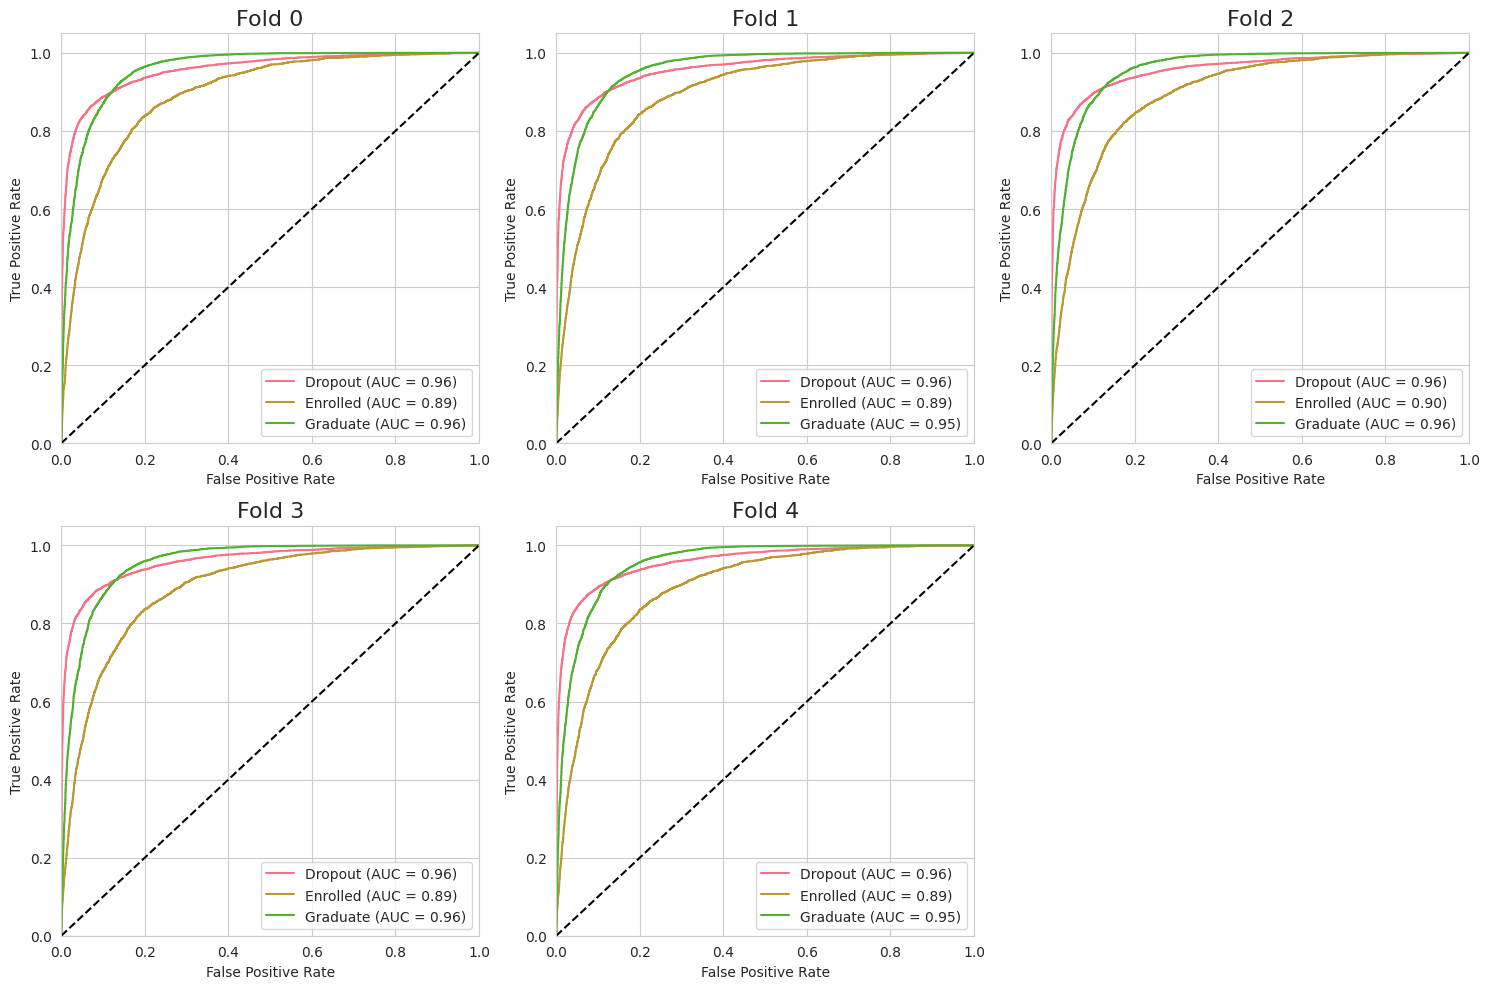

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs.values[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{reverse_mappings[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

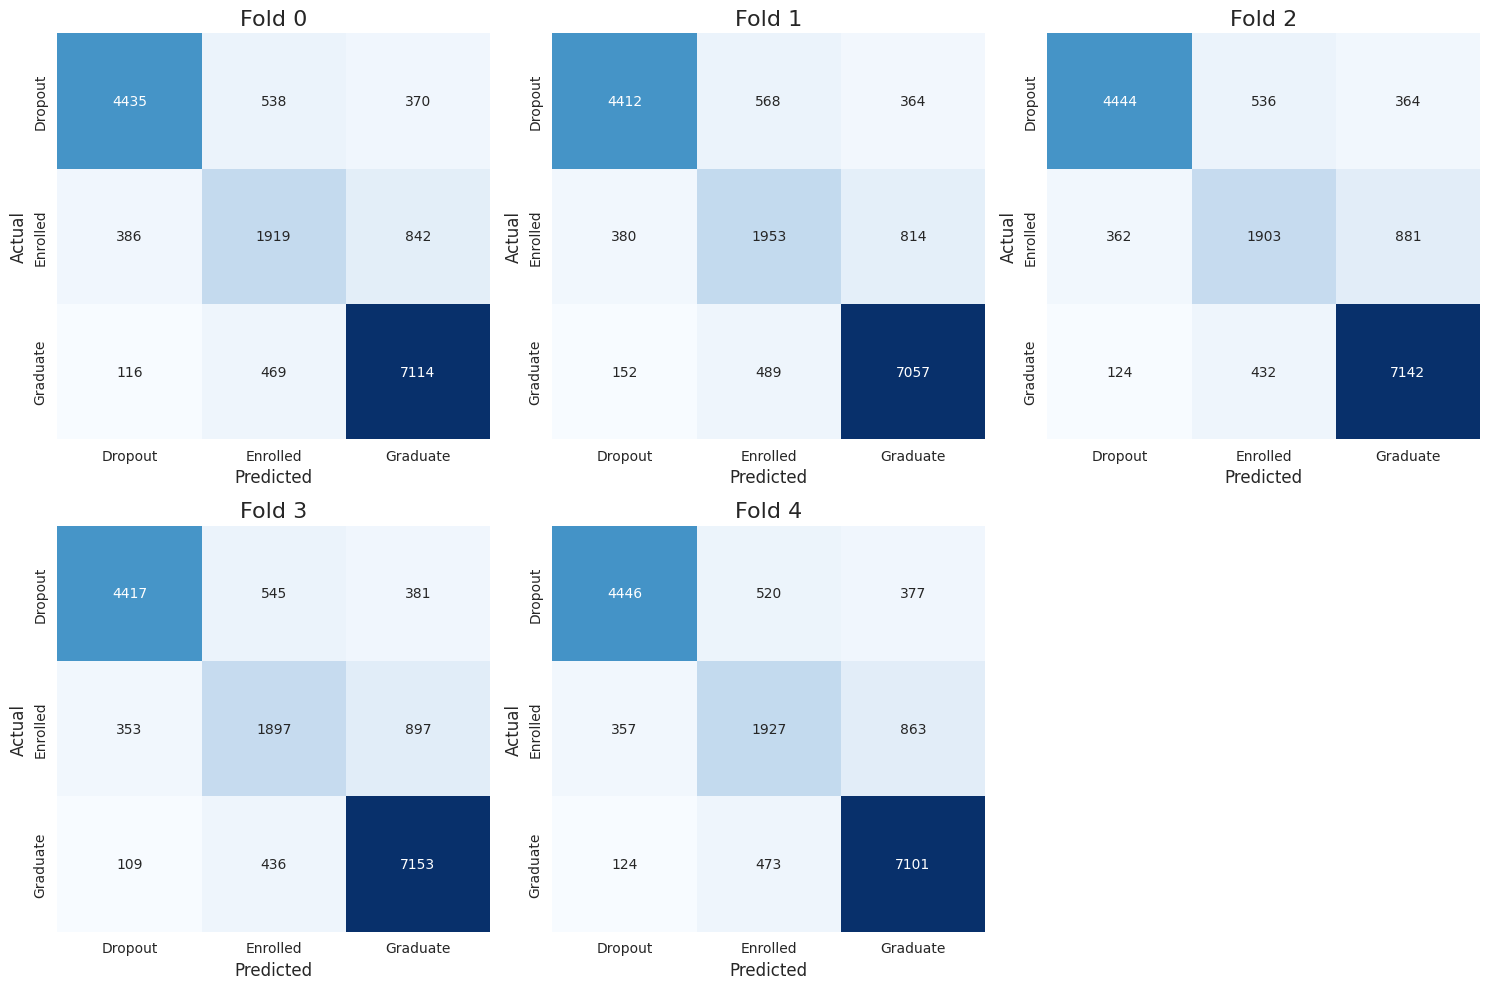

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=reverse_mappings.values(),
        yticklabels=reverse_mappings.values()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

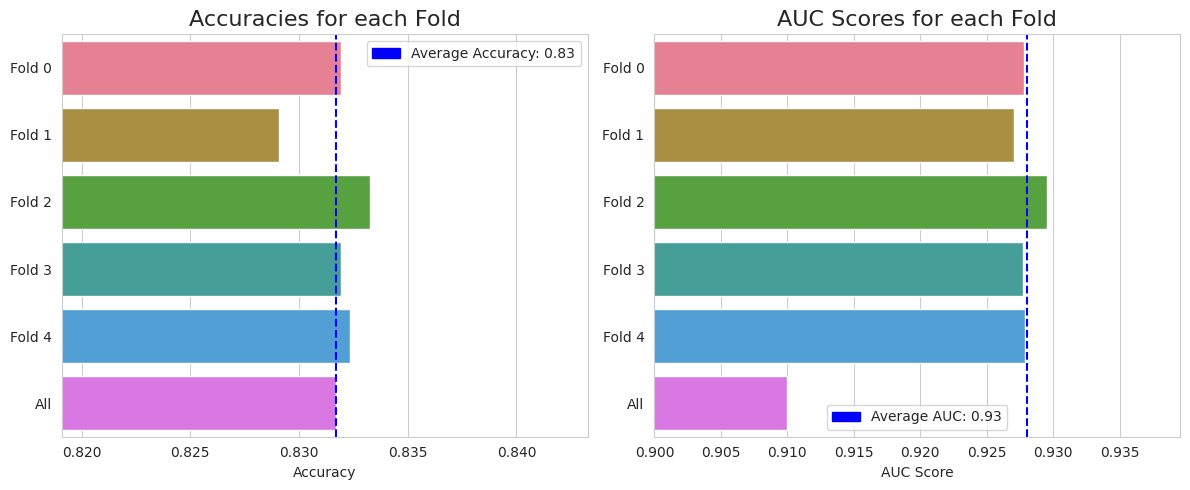

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='b', linestyle='--')
axs[0].set_xlim([min(accuracies) - 0.01, max(accuracies) + 0.01])
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='b', label=f'Average Accuracy: {mean_accuracy:.2f}')
axs[0].legend(handles=[blue_patch], loc='best')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='b', linestyle='--')
axs[1].set_xlim([min(auc_scores) - 0.01, max(auc_scores) + 0.01])
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='b', label=f'Average AUC: {mean_auc:.2f}')
axs[1].legend(handles=[blue_patch], loc='best')

plt.tight_layout()
plt.show()

# Inference

In [18]:
files = glob.glob('fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'sub_ag_acc_{mean_accuracy:.6f}_auc_{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Graduate
76522,76522,Enrolled
